<div align="center"><b> APSERa Simulation for 2-4 GHz </b></div>


<div align="center"><b> Importing required packages </b></div>


In [1]:
#The following code is written using GlobalSkyModel and not GlobalSkyModel2016. The difference is just the units, and that can be modified anytime.

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem

%matplotlib inline

from pygsm import GlobalSkyModel
from ms_fit_joint import ms_fit, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline



In [2]:
start_time_in_UTC = '2012-05-20 1:45:00'
n_spectra = 24
delta_t_in_hours = 1

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')
print(t)

ts = TimeSeries(time_start= '2012-05-20 1:45:00', time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)



2012-05-20 01:45:00.000
['2012-05-20 01:45:00.000' '2012-05-20 02:45:00.000'
 '2012-05-20 03:45:00.000' '2012-05-20 04:45:00.000'
 '2012-05-20 05:45:00.000' '2012-05-20 06:45:00.000'
 '2012-05-20 07:45:00.000' '2012-05-20 08:45:00.000'
 '2012-05-20 09:45:00.000' '2012-05-20 10:45:00.000'
 '2012-05-20 11:45:00.000' '2012-05-20 12:45:00.000'
 '2012-05-20 13:45:00.000' '2012-05-20 14:45:00.000'
 '2012-05-20 15:45:00.000' '2012-05-20 16:45:00.000'
 '2012-05-20 17:45:00.000' '2012-05-20 18:45:00.000'
 '2012-05-20 19:45:00.000' '2012-05-20 20:45:00.000'
 '2012-05-20 21:45:00.000' '2012-05-20 22:45:00.000'
 '2012-05-20 23:45:00.000' '2012-05-21 00:45:00.000']


<div align="center"><b> Definitions </b></div>


In [3]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2
f_stop = 4
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730         #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = 13.067439
longitude = 80.237617       #Latitude and longitude in degrees
altitude = 0            #Altitude in meters
alpha = 0.0065            #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 2.7e10
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real = [0]*No_of_Channels
cross_imag = [0]*No_of_Channels
sumwt = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra = [0]*n_spectra
spectra_cross_imag = [0]*n_spectra


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R

#Beam definition
def beam_def(freq, az, alt):
    if (alt<=0):
        return 0
    else:
        return (math.sin(alt*PI/180)*math.sin(alt*PI/180))
    
print(Time_in_UTC[0])
    

2012-05-20 01:45:00.000


<div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [4]:
freq_split = (np.array_split(freqs, 6))
gsm = GlobalSkyModel(freq_unit='GHz')

#The gsm values can be extracted in a single line of code. I broke into 6 lines and joined again, as my system can't handle! 

spectrum1 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[0]))), N_SIDE)
spectrum2 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[1]))), N_SIDE)
spectrum3 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[2]))), N_SIDE)
spectrum4 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[3]))), N_SIDE)
spectrum5 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[4]))), N_SIDE)
spectrum6 = hp.pixelfunc.ud_grade((np.array(gsm.generate(freq_split[5]))), N_SIDE)


map_1 = (np.concatenate((spectrum1, spectrum2, spectrum3, spectrum4,spectrum5, spectrum6), axis=0))

#The map is in antennae Temp units. The below line is to convert it into same power units 
map_1 = 2*k*map_1         # = 2kT (Still a bit confused if this is correct)


CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
CMB_Int_RJ = CMB_Int * c*c/ (1e+18* freqs**2)

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold



<div align="center"><b> Getting recombination lines </b></div>


In [5]:
NPIX = hp.nside2npix(N_SIDE)
#df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df = pd.read_csv(r'/home/mayuris/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)

#Converting into same power units as CMB and rec line 
Rec_int = Rec_int *  c*c/ (1e+18* freqs**2)


/home/mayuris/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


<div align="center"><b> Getting temperature values after calibration </b></div>


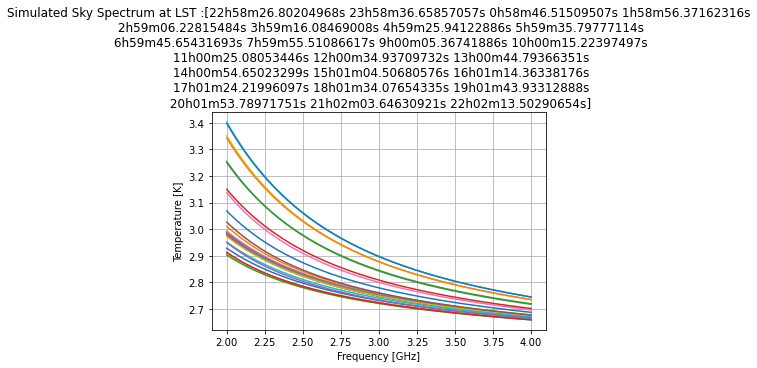

In [6]:
k = 0
while k<n_spectra:
    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')
        
        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[k], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
    
    
    
        j=0
        while j< No_of_Channels:
            cwt = beam_def(freqs[j],equi.az.value, new_alt)
        
            if (cwt>0):     #Adding all 3 intensities
                Power = map_1[j][i-1] + Rec_int[j] + CMB_Int_RJ[j]
                final_temp = (Power/P_dif[j])*(T_hot-T_cold)
                cross_real[j] = cross_real[j] + cwt*final_temp
                sumwt[j] = sumwt[j]+ cwt
            
            j = j+1
        
    
        i = i+1

    
    i=0    
    while(i< No_of_Channels):
        if sumwt[i]>0:
            cross_real[i] = cross_real[i]/sumwt[i]
        i = i+1
        
    sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)    
    array = np.random.normal(0,1,No_of_Channels)

    cross_real = cross_real + array*sigma
    cross_imag = cross_imag + array*sigma
    
    spectra[k] = cross_real
    spectra_cross_imag[k] = cross_imag
    
    cross_real = [0]*No_of_Channels
    cross_imag = [0]*No_of_Channels
    sumwt = [0]*No_of_Channels
    sigma = [0]*No_of_Channels
    
    k = k+1

Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
lst = t.sidereal_time('apparent')
    

i=0
while(i<n_spectra):
    plt.plot(freqs, spectra[i])
    i=i+1
    
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum at LST :%s'%lst)
plt.grid()
plt.show()




In [7]:
with open("Data.txt",'w') as fh:
    fh.write(repr(spectra))
fh.close()

(24, 201)


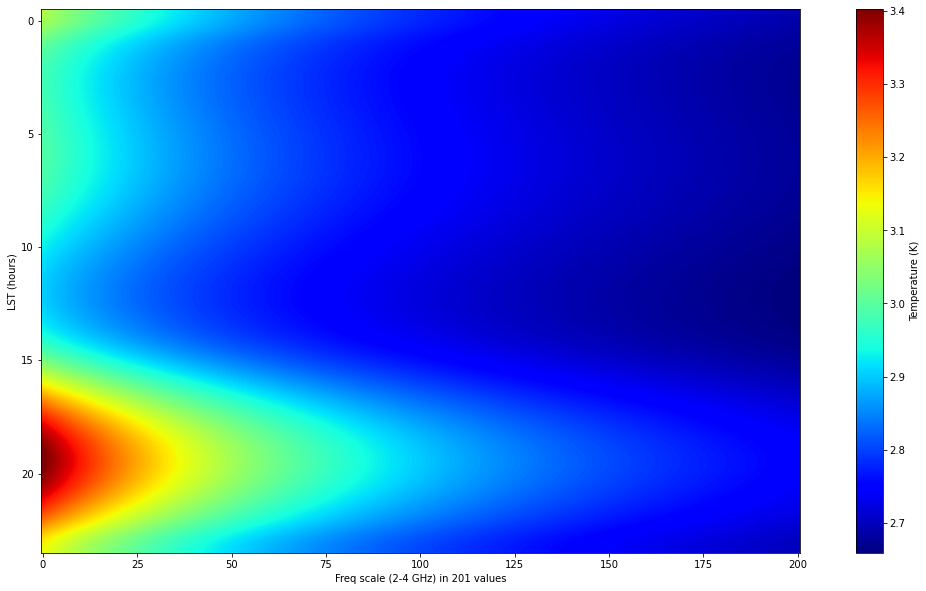

In [8]:
x = freqs
Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
y = np.array(lst)
z = np.array(spectra)

print(z.shape)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.imshow(z,cmap= 'jet',aspect='6',interpolation= 'spline16')
bar = plt.colorbar()
plt.xlabel('Freq scale (2-4 GHz) in 201 values')
plt.ylabel('LST (hours)')
bar.set_label('Temperature (K)')
plt.show()

In [9]:
#Added this cell code above!


# #Adding thermal noise to the final spectrum    
# #For the total power radiometer:
# sigma = (np.array(cross_real) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)

# #Uncomment for checking seperate intensities    
# #sigma1 = (np.array(cross_real1) + Trx+ T_atm)/ math.sqrt(Channel_width*1e6*Noise_int_time)


# #Generating array of random numbers(of length = No.of channels) with mean =0, std = 1 
# array = np.random.normal(0,1,No_of_Channels)

# cross_real = cross_real + array*sigma
# cross_imag = cross_imag + array*sigma

# #Uncomment for checking seperate intensities   
# # cross_real1 = cross_real1 + array*sigma1
# # cross_imag1 = cross_imag1 + array*sigma1



In [10]:
#Added this cell code above! 

#Obs = ephem.Observer()
# t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
# lst = t.sidereal_time('apparent')

  
# plt.plot(freqs, spectra, color = 'orange')
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum at LST :%s'%lst)
# plt.grid()
# plt.show()


# plt.plot(freqs, spectra_cross_imag, color = 'orange')
# plt.xlabel('Frequency [GHz]')
# plt.ylabel('Temperature [K]')
# plt.title('Simulated Sky Spectrum for noise integration time of : %.2E seconds'%Noise_int_time)
# plt.grid()
# plt.show()

<div align="center"><b> Fitting with Maxsmooth function </b></div>


In [11]:
#Trying with one cross_real value

#Using maxsmooth function
result = smooth(freqs, cross_real, 14)
C = result.y_fit

#Uncomment for checking seperate intensities 
# result1 = smooth(freqs, cross_real1, 14)
# D = result1.y_fit

plt.plot(freqs, cross_real- C, color = 'black')
#plt.plot(freqs, cross_real1- D, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
plt.show()

#df = pd.read_csv(r'/home/dhashin/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df = pd.read_csv(r'/home/mayuris/workspace/APSERa/total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]
plt.plot(df['Frequency'], df['Intensity'])
plt.title('Recombination intensity')
plt.xlim([2,4])
plt.ylim([5e-28,9e-28])
plt.grid()
plt.show()

AttributeError: 'list' object has no attribute 'astype'

<div align="center"><b> Fitting with MS_fit function </b></div>


In [ ]:
#Trying with once cross_real value


Res = (ms_fit(freqs, cross_real, norder = 8, error = cross_imag))
#Res1 = (ms_fit(freqs, cross_real1, norder = 8, error = cross_imag1))

#Res[5] gives the residual value after fitting. Res[5] array and Res[4] has only 200 values, while input 201 values. Not sure why. For plotting,I just added one term 
Res5 = Res[5]
Res5 = np.append(Res5, Res5[No_of_Channels - 2])

#Res[4] gives the fitting function
Res4 = Res[4]
Res4 = np.append(Res4, Res4[No_of_Channels - 2])

plt.plot(freqs, Res5, color = 'blue')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')
plt.title('Simulated Sky Spectrum residual')
plt.grid()
#plt.ylim([-0.002,0.002])
plt.show()

<div align="center"><b> Fitting with 'custom' MS_fit function </b></div>


In [ ]:
#Will check that